In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

### Function to create a distribution of elements with fixed number of elements per bin
The ideia is that np.interp will interpolate a set of elements such that a fixed number of elements will be comprised in each interval of the interpolated function. <br>

We want a fixed number of objects per bin to compute the mean $\sigma_{nmad}$ per magnitude bin



In [2]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

### Reading photo-z training set table and plotting

In [3]:
training_set = pd.read_csv("Results_DF.csv", usecols=['r_aper_6', 'zml', 'z'])

In [4]:
rmag = training_set["r_aper_6"]
zml = training_set["zml"]
z = training_set["z"]

Text(0.5, 1.0, 'R_aper_6 histogram with fixed bin widths')

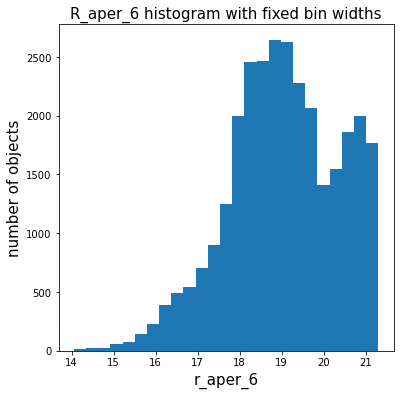

In [5]:
fontsize=15

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.hist(rmag, 25, histtype='bar', rwidth=1.0)
ax.set_xlabel("r_aper_6", fontsize=fontsize)
ax.set_ylabel("number of objects", fontsize=fontsize)
ax.set_title("R_aper_6 histogram with fixed bin widths", fontsize=fontsize)

Text(0.5, 1.0, 'R_aper_6 histogram with fixed number of objects per bin')

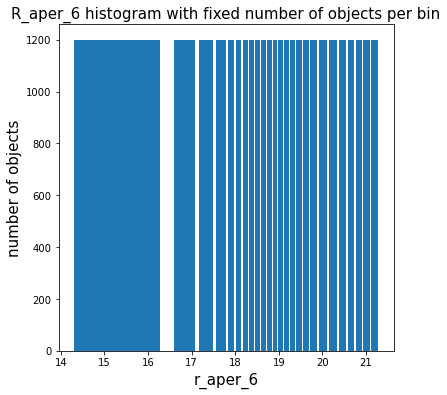

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(rmag, histedges_equalN(rmag, 25), histtype='bar', rwidth=0.8)
ax.set_xlabel("r_aper_6", fontsize=fontsize)
ax.set_ylabel("number of objects", fontsize=fontsize)
ax.set_title("R_aper_6 histogram with fixed number of objects per bin", fontsize=fontsize)

### Calculating mean sigma_nmad's for each of those magnitude bins

In [7]:
mag = np.array(bins)
sigma_nmad = []
mag_bins = []

for i in range(1, len(mag), 1):
    mask = (rmag > mag[i-1]) & (rmag < mag[i])
    delta_z = zml[mask] - z[mask]
    sigma_nmad.append(np.abs(1.48 * np.median(abs(delta_z - np.median(delta_z)) / (1 + z[mask]))))
    mag_bins.append("{:.3f} <= r_mag <= {:.3f}".format(mag[i-1], mag[i]))

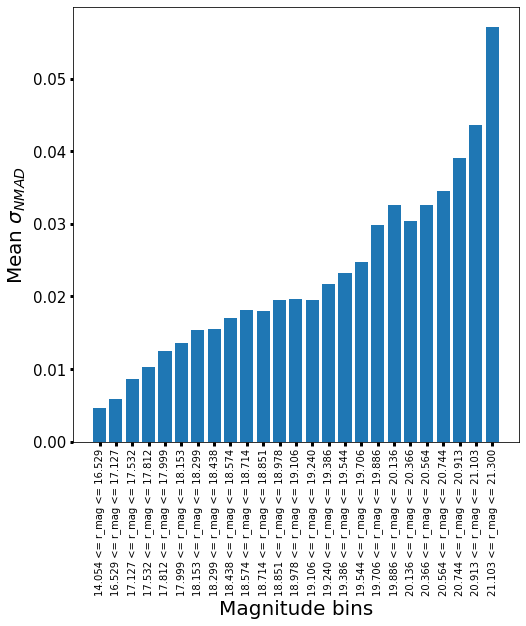

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.bar(mag_bins, sigma_nmad)
ax.set_xlabel("Magnitude bins", fontsize=20)
ax.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=20)
ax.xaxis.set_tick_params(labelsize=10, width=3, rotation=90)
ax.yaxis.set_tick_params(labelsize=15, width=3)

### Fit curve to the distribution of sigma_nmads

In [9]:
from scipy.optimize import curve_fit

In [10]:
def func1(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [11]:
#The bin (13, 2e-3) was added to extend the function down to r~13
sigma_nmad_new = np.concatenate((np.array([2e-3]), sigma_nmad))
mag_new = np.concatenate((np.array([13.00]), mag))

xdata = mag_new[:-1]
ydata = sigma_nmad_new

popt1, pcov1 = curve_fit(func1, xdata, ydata)

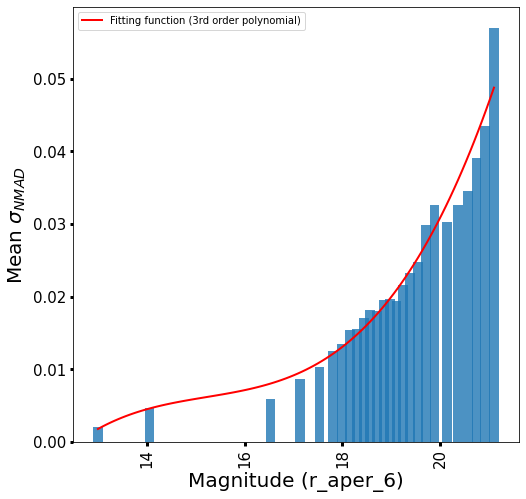

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

xnew = np.linspace(xdata[0], xdata[-1], 100)
# ax.scatter(xdata, ydata)
ax.bar(mag_new[:-1], sigma_nmad_new, alpha=0.8, width=0.2)
ax.plot(xnew, func1(xnew, *popt1), linewidth=2.0, color='red', label="Fitting function (3rd order polynomial)")
ax.set_xlabel("Magnitude (r_aper_6)", fontsize=20)
ax.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=20)
ax.xaxis.set_tick_params(labelsize=15, width=3, rotation=90)
ax.yaxis.set_tick_params(labelsize=15, width=3)
ax.legend()

### Use the fitted function to perform the photo-z selection

#### 1. Targets from Legacy crossmatched with S-PLUS
Legacy: RMAG < 20.5; SG = 0; PRIMARY = 1 <br>
SPLUS: SEX_FLAGS_DET < 4; r_petro < 21; 1400 <= X_IMAGE <= 10100; 1200 <= Y_IMAGE <= 9500 <br>
Crossmatch: 2 arcsecs

In [15]:
#Input the path to the table here
table_targets_path = "tables-photometric/Hydra-InSPLUS-AndLegacy-CHANCES.csv"

In [16]:
table_targets = pd.read_csv(table_targets_path, usecols=['OBJECT_ID', 'RA_J2000', 'Dec_J2000', 
                                                                             'zml', 'RFIBER', 'RMAG'])

In [17]:
objid =table_targets["OBJECT_ID"]
ra = table_targets["RA_J2000"]
dec = table_targets["Dec_J2000"]
zml = table_targets["zml"]
rfiber = table_targets["RFIBER"]
rmag = table_targets["RMAG"]

In [18]:
#Input here the redshift of the cluster (0.012 is the redshift of Hydra in this example):
z_cluster = 0.012

In [21]:
dfs = []
n = 0
f = 4

for r in np.unique(rmag):   
#The idea here is to use the sigma_nmad function above r~16.5, and a constant value of sigma_nmad under r~16.5 
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
      
    if ((z_cluster - f*sigma_nmad) >= 0):
        mask = (rmag == r) & (zml > (z_cluster - (f*sigma_nmad))) & (zml < (z_cluster + (f*sigma_nmad)))
        
    elif ((z_cluster - f*sigma_nmad) < 0):
        mask = (rmag == r) & (zml > 0) & (zml < (z_cluster + (f*sigma_nmad)))

    n += np.sum(mask)
    print("Total number of objects: {:6d}".format(n))
    
    dfs.append(table_targets.loc[np.isin(objid, objid[mask])])
    
final_catalogue = pd.concat(dfs, ignore_index=True)

Total number of objects:      1
Total number of objects:      2
Total number of objects:      3
Total number of objects:      4
Total number of objects:      5
Total number of objects:      6
Total number of objects:      7
Total number of objects:      8
Total number of objects:      9
Total number of objects:     10
Total number of objects:     10
Total number of objects:     11
Total number of objects:     12
Total number of objects:     13
Total number of objects:     14
Total number of objects:     15
Total number of objects:     16
Total number of objects:     17
Total number of objects:     18
Total number of objects:     19
Total number of objects:     20
Total number of objects:     21
Total number of objects:     22
Total number of objects:     23
Total number of objects:     24
Total number of objects:     25
Total number of objects:     26
Total number of objects:     27
Total number of objects:     28
Total number of objects:     29
Total number of objects:     30
Total nu

Total number of objects:    245
Total number of objects:    246
Total number of objects:    247
Total number of objects:    248
Total number of objects:    248
Total number of objects:    248
Total number of objects:    249
Total number of objects:    250
Total number of objects:    251
Total number of objects:    252
Total number of objects:    252
Total number of objects:    252
Total number of objects:    252
Total number of objects:    252
Total number of objects:    252
Total number of objects:    253
Total number of objects:    253
Total number of objects:    254
Total number of objects:    255
Total number of objects:    256
Total number of objects:    256
Total number of objects:    257
Total number of objects:    258
Total number of objects:    259
Total number of objects:    259
Total number of objects:    260
Total number of objects:    261
Total number of objects:    262
Total number of objects:    263
Total number of objects:    264
Total number of objects:    265
Total nu

Total number of objects:    500
Total number of objects:    500
Total number of objects:    500
Total number of objects:    501
Total number of objects:    501
Total number of objects:    501
Total number of objects:    502
Total number of objects:    502
Total number of objects:    502
Total number of objects:    502
Total number of objects:    502
Total number of objects:    502
Total number of objects:    502
Total number of objects:    503
Total number of objects:    503
Total number of objects:    503
Total number of objects:    504
Total number of objects:    504
Total number of objects:    505
Total number of objects:    506
Total number of objects:    506
Total number of objects:    507
Total number of objects:    507
Total number of objects:    507
Total number of objects:    508
Total number of objects:    509
Total number of objects:    509
Total number of objects:    509
Total number of objects:    509
Total number of objects:    509
Total number of objects:    510
Total nu

Total number of objects:    579
Total number of objects:    579
Total number of objects:    579
Total number of objects:    579
Total number of objects:    579
Total number of objects:    579
Total number of objects:    579
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    580
Total number of objects:    581
Total number of objects:    581
Total number of objects:    581
Total number of objects:    581
Total number of objects:    581
Total number of objects:    582
Total number of objects:    583
Total number of objects:    584
Total nu

Total number of objects:    640
Total number of objects:    640
Total number of objects:    640
Total number of objects:    640
Total number of objects:    641
Total number of objects:    641
Total number of objects:    641
Total number of objects:    641
Total number of objects:    641
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    642
Total number of objects:    643
Total number of objects:    644
Total nu

Total number of objects:    701
Total number of objects:    701
Total number of objects:    701
Total number of objects:    701
Total number of objects:    702
Total number of objects:    703
Total number of objects:    703
Total number of objects:    704
Total number of objects:    704
Total number of objects:    704
Total number of objects:    705
Total number of objects:    705
Total number of objects:    705
Total number of objects:    705
Total number of objects:    706
Total number of objects:    706
Total number of objects:    707
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total number of objects:    708
Total nu

Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    752
Total number of objects:    753
Total number of objects:    754
Total number of objects:    754
Total number of objects:    754
Total number of objects:    754
Total number of objects:    755
Total number of objects:    755
Total number of objects:    756
Total number of objects:    756
Total number of objects:    756
Total number of objects:    756
Total nu

Total number of objects:    809
Total number of objects:    809
Total number of objects:    809
Total number of objects:    810
Total number of objects:    810
Total number of objects:    810
Total number of objects:    811
Total number of objects:    812
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    813
Total number of objects:    814
Total number of objects:    814
Total number of objects:    814
Total number of objects:    814
Total number of objects:    814
Total nu

Total number of objects:    852
Total number of objects:    853
Total number of objects:    853
Total number of objects:    853
Total number of objects:    853
Total number of objects:    853
Total number of objects:    854
Total number of objects:    854
Total number of objects:    854
Total number of objects:    855
Total number of objects:    855
Total number of objects:    855
Total number of objects:    855
Total number of objects:    855
Total number of objects:    855
Total number of objects:    855
Total number of objects:    855
Total number of objects:    856
Total number of objects:    856
Total number of objects:    856
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total number of objects:    857
Total nu

Total number of objects:    900
Total number of objects:    901
Total number of objects:    901
Total number of objects:    901
Total number of objects:    901
Total number of objects:    901
Total number of objects:    901
Total number of objects:    901
Total number of objects:    902
Total number of objects:    902
Total number of objects:    902
Total number of objects:    903
Total number of objects:    903
Total number of objects:    904
Total number of objects:    904
Total number of objects:    905
Total number of objects:    905
Total number of objects:    905
Total number of objects:    905
Total number of objects:    905
Total number of objects:    905
Total number of objects:    905
Total number of objects:    905
Total number of objects:    907
Total number of objects:    908
Total number of objects:    908
Total number of objects:    908
Total number of objects:    908
Total number of objects:    908
Total number of objects:    909
Total number of objects:    910
Total nu

Total number of objects:    955
Total number of objects:    955
Total number of objects:    955
Total number of objects:    955
Total number of objects:    955
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    956
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    957
Total number of objects:    958
Total number of objects:    958
Total number of objects:    958
Total number of objects:    958
Total nu

Total number of objects:    995
Total number of objects:    996
Total number of objects:    997
Total number of objects:    997
Total number of objects:    997
Total number of objects:    997
Total number of objects:    997
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    998
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total number of objects:    999
Total nu

Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1039
Total number of objects:   1040
Total number of objects:   1040
Total number of objects:   1040
Total number of objects:   1041
Total number of objects:   1041
Total number of objects:   1041
Total number of objects:   1041
Total number of objects:   1042
Total number of objects:   1042
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1043
Total number of objects:   1044
Total nu

Total number of objects:   1080
Total number of objects:   1081
Total number of objects:   1082
Total number of objects:   1082
Total number of objects:   1082
Total number of objects:   1082
Total number of objects:   1082
Total number of objects:   1082
Total number of objects:   1082
Total number of objects:   1083
Total number of objects:   1083
Total number of objects:   1083
Total number of objects:   1084
Total number of objects:   1084
Total number of objects:   1084
Total number of objects:   1084
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total number of objects:   1085
Total nu

Total number of objects:   1128
Total number of objects:   1128
Total number of objects:   1128
Total number of objects:   1129
Total number of objects:   1129
Total number of objects:   1129
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1130
Total number of objects:   1131
Total number of objects:   1131
Total number of objects:   1131
Total number of objects:   1132
Total number of objects:   1133
Total number of objects:   1133
Total number of objects:   1133
Total number of objects:   1134
Total number of objects:   1134
Total number of objects:   1134
Total number of objects:   1134
Total number of objects:   1134
Total number of objects:   1135
Total number of objects:   1135
Total number of objects:   1135
Total number of objects:   1135
Total nu

Total number of objects:   1168
Total number of objects:   1168
Total number of objects:   1169
Total number of objects:   1169
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1170
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1171
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total number of objects:   1172
Total nu

Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1220
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1221
Total number of objects:   1222
Total number of objects:   1222
Total number of objects:   1222
Total number of objects:   1223
Total number of objects:   1223
Total number of objects:   1224
Total number of objects:   1224
Total number of objects:   1224
Total number of objects:   1224
Total number of objects:   1224
Total number of objects:   1225
Total number of objects:   1225
Total nu

Total number of objects:   1275
Total number of objects:   1275
Total number of objects:   1275
Total number of objects:   1275
Total number of objects:   1275
Total number of objects:   1275
Total number of objects:   1275
Total number of objects:   1276
Total number of objects:   1276
Total number of objects:   1276
Total number of objects:   1276
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1277
Total number of objects:   1278
Total number of objects:   1278
Total number of objects:   1278
Total number of objects:   1279
Total number of objects:   1279
Total number of objects:   1279
Total number of objects:   1279
Total nu

Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1316
Total number of objects:   1317
Total number of objects:   1317
Total number of objects:   1317
Total number of objects:   1317
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total number of objects:   1318
Total nu

Total number of objects:   1354
Total number of objects:   1354
Total number of objects:   1354
Total number of objects:   1354
Total number of objects:   1354
Total number of objects:   1355
Total number of objects:   1355
Total number of objects:   1355
Total number of objects:   1355
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1356
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1357
Total number of objects:   1358
Total nu

Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1396
Total number of objects:   1397
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1398
Total number of objects:   1399
Total number of objects:   1399
Total nu

Total number of objects:   1440
Total number of objects:   1440
Total number of objects:   1440
Total number of objects:   1440
Total number of objects:   1441
Total number of objects:   1441
Total number of objects:   1441
Total number of objects:   1441
Total number of objects:   1441
Total number of objects:   1441
Total number of objects:   1441
Total number of objects:   1442
Total number of objects:   1442
Total number of objects:   1442
Total number of objects:   1443
Total number of objects:   1443
Total number of objects:   1443
Total number of objects:   1444
Total number of objects:   1444
Total number of objects:   1444
Total number of objects:   1445
Total number of objects:   1445
Total number of objects:   1446
Total number of objects:   1446
Total number of objects:   1447
Total number of objects:   1447
Total number of objects:   1447
Total number of objects:   1447
Total number of objects:   1447
Total number of objects:   1447
Total number of objects:   1447
Total nu

Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1508
Total number of objects:   1509
Total number of objects:   1509
Total number of objects:   1509
Total number of objects:   1509
Total number of objects:   1509
Total number of objects:   1510
Total number of objects:   1510
Total number of objects:   1510
Total number of objects:   1511
Total number of objects:   1511
Total number of objects:   1511
Total number of objects:   1511
Total number of objects:   1511
Total number of objects:   1511
Total number of objects:   1512
Total number of objects:   1512
Total number of objects:   1512
Total number of objects:   1513
Total number of objects:   1513
Total number of objects:   1513
Total number of objects:   1513
Total number of objects:   1513
Total nu

Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1562
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total number of objects:   1563
Total nu

Total number of objects:   1607
Total number of objects:   1607
Total number of objects:   1607
Total number of objects:   1607
Total number of objects:   1608
Total number of objects:   1608
Total number of objects:   1608
Total number of objects:   1609
Total number of objects:   1609
Total number of objects:   1609
Total number of objects:   1609
Total number of objects:   1609
Total number of objects:   1609
Total number of objects:   1610
Total number of objects:   1610
Total number of objects:   1610
Total number of objects:   1610
Total number of objects:   1610
Total number of objects:   1610
Total number of objects:   1610
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total number of objects:   1612
Total nu

Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1658
Total number of objects:   1659
Total number of objects:   1660
Total number of objects:   1660
Total number of objects:   1660
Total number of objects:   1660
Total number of objects:   1661
Total number of objects:   1661
Total number of objects:   1662
Total number of objects:   1663
Total number of objects:   1663
Total number of objects:   1663
Total number of objects:   1663
Total number of objects:   1664
Total number of objects:   1664
Total number of objects:   1665
Total number of objects:   1665
Total number of objects:   1665
Total number of objects:   1665
Total number of objects:   1665
Total number of objects:   1666
Total number of objects:   1666
Total nu

Total number of objects:   1722
Total number of objects:   1722
Total number of objects:   1722
Total number of objects:   1723
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1724
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1725
Total number of objects:   1726
Total number of objects:   1726
Total number of objects:   1727
Total number of objects:   1727
Total number of objects:   1728
Total number of objects:   1728
Total number of objects:   1728
Total number of objects:   1728
Total number of objects:   1728
Total number of objects:   1729
Total number of objects:   1729
Total nu

Total number of objects:   1781
Total number of objects:   1781
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1782
Total number of objects:   1783
Total number of objects:   1783
Total number of objects:   1783
Total number of objects:   1783
Total number of objects:   1783
Total number of objects:   1784
Total number of objects:   1786
Total number of objects:   1787
Total number of objects:   1787
Total number of objects:   1787
Total number of objects:   1787
Total number of objects:   1787
Total number of objects:   1788
Total nu

Total number of objects:   1856
Total number of objects:   1856
Total number of objects:   1856
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1857
Total number of objects:   1858
Total number of objects:   1858
Total number of objects:   1858
Total number of objects:   1858
Total number of objects:   1858
Total number of objects:   1858
Total number of objects:   1858
Total number of objects:   1859
Total number of objects:   1859
Total number of objects:   1859
Total number of objects:   1860
Total number of objects:   1860
Total number of objects:   1860
Total number of objects:   1860
Total number of objects:   1860
Total number of objects:   1861
Total number of objects:   1861
Total number of objects:   1861
Total number of objects:   1861
Total nu

Total number of objects:   1922
Total number of objects:   1922
Total number of objects:   1922
Total number of objects:   1922
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1923
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1924
Total number of objects:   1925
Total number of objects:   1925
Total nu

Total number of objects:   1980
Total number of objects:   1980
Total number of objects:   1980
Total number of objects:   1980
Total number of objects:   1980
Total number of objects:   1980
Total number of objects:   1981
Total number of objects:   1982
Total number of objects:   1983
Total number of objects:   1984
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1985
Total number of objects:   1988
Total number of objects:   1988
Total number of objects:   1988
Total number of objects:   1989
Total number of objects:   1989
Total number of objects:   1989
Total number of objects:   1989
Total number of objects:   1989
Total number of objects:   1989
Total number of objects:   1989
Total nu

Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2040
Total number of objects:   2041
Total number of objects:   2041
Total number of objects:   2042
Total number of objects:   2042
Total number of objects:   2042
Total number of objects:   2042
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2043
Total number of objects:   2044
Total number of objects:   2044
Total nu

Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2091
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2092
Total number of objects:   2093
Total number of objects:   2093
Total number of objects:   2093
Total number of objects:   2093
Total nu

Total number of objects:   2146
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2147
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2148
Total number of objects:   2149
Total number of objects:   2150
Total number of objects:   2150
Total number of objects:   2151
Total number of objects:   2152
Total number of objects:   2152
Total number of objects:   2152
Total number of objects:   2152
Total nu

Total number of objects:   2224
Total number of objects:   2225
Total number of objects:   2225
Total number of objects:   2225
Total number of objects:   2226
Total number of objects:   2226
Total number of objects:   2226
Total number of objects:   2227
Total number of objects:   2227
Total number of objects:   2228
Total number of objects:   2228
Total number of objects:   2229
Total number of objects:   2229
Total number of objects:   2229
Total number of objects:   2229
Total number of objects:   2229
Total number of objects:   2229
Total number of objects:   2229
Total number of objects:   2230
Total number of objects:   2230
Total number of objects:   2230
Total number of objects:   2231
Total number of objects:   2231
Total number of objects:   2231
Total number of objects:   2231
Total number of objects:   2232
Total number of objects:   2232
Total number of objects:   2232
Total number of objects:   2232
Total number of objects:   2232
Total number of objects:   2233
Total nu

Total number of objects:   2284
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2285
Total number of objects:   2286
Total number of objects:   2287
Total number of objects:   2289
Total number of objects:   2289
Total number of objects:   2289
Total number of objects:   2291
Total number of objects:   2292
Total number of objects:   2292
Total number of objects:   2292
Total number of objects:   2292
Total number of objects:   2292
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total number of objects:   2293
Total nu

Total number of objects:   2344
Total number of objects:   2344
Total number of objects:   2344
Total number of objects:   2344
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2345
Total number of objects:   2346
Total number of objects:   2346
Total number of objects:   2346
Total number of objects:   2347
Total number of objects:   2347
Total number of objects:   2347
Total number of objects:   2347
Total number of objects:   2347
Total number of objects:   2347
Total number of objects:   2347
Total number of objects:   2348
Total number of objects:   2349
Total number of objects:   2349
Total number of objects:   2349
Total number of objects:   2351
Total number of objects:   2352
Total nu

Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2406
Total number of objects:   2407
Total number of objects:   2407
Total number of objects:   2407
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2408
Total number of objects:   2409
Total number of objects:   2409
Total number of objects:   2410
Total number of objects:   2411
Total number of objects:   2412
Total nu

Total number of objects:   2475
Total number of objects:   2475
Total number of objects:   2476
Total number of objects:   2477
Total number of objects:   2477
Total number of objects:   2478
Total number of objects:   2478
Total number of objects:   2478
Total number of objects:   2478
Total number of objects:   2478
Total number of objects:   2479
Total number of objects:   2479
Total number of objects:   2479
Total number of objects:   2480
Total number of objects:   2480
Total number of objects:   2480
Total number of objects:   2480
Total number of objects:   2481
Total number of objects:   2482
Total number of objects:   2482
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2483
Total number of objects:   2484
Total number of objects:   2484
Total number of objects:   2484
Total nu

Total number of objects:   2532
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2534
Total number of objects:   2535
Total number of objects:   2536
Total number of objects:   2536
Total number of objects:   2537
Total number of objects:   2538
Total number of objects:   2538
Total number of objects:   2538
Total number of objects:   2538
Total number of objects:   2539
Total number of objects:   2539
Total number of objects:   2539
Total number of objects:   2540
Total number of objects:   2540
Total number of objects:   2540
Total number of objects:   2541
Total number of objects:   2541
Total number of objects:   2541
Total number of objects:   2541
Total number of objects:   2541
Total number of objects:   2541
Total number of objects:   2541
Total number of objects:   2541
Total nu

Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2609
Total number of objects:   2610
Total number of objects:   2611
Total number of objects:   2611
Total number of objects:   2611
Total number of objects:   2611
Total number of objects:   2612
Total nu

Total number of objects:   2683
Total number of objects:   2683
Total number of objects:   2683
Total number of objects:   2683
Total number of objects:   2683
Total number of objects:   2683
Total number of objects:   2684
Total number of objects:   2684
Total number of objects:   2684
Total number of objects:   2684
Total number of objects:   2684
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total number of objects:   2685
Total nu

Total number of objects:   2767
Total number of objects:   2767
Total number of objects:   2767
Total number of objects:   2767
Total number of objects:   2769
Total number of objects:   2770
Total number of objects:   2771
Total number of objects:   2771
Total number of objects:   2773
Total number of objects:   2773
Total number of objects:   2773
Total number of objects:   2773
Total number of objects:   2773
Total number of objects:   2774
Total number of objects:   2775
Total number of objects:   2775
Total number of objects:   2776
Total number of objects:   2776
Total number of objects:   2776
Total number of objects:   2776
Total number of objects:   2777
Total number of objects:   2778
Total number of objects:   2778
Total number of objects:   2779
Total number of objects:   2779
Total number of objects:   2779
Total number of objects:   2779
Total number of objects:   2779
Total number of objects:   2779
Total number of objects:   2779
Total number of objects:   2779
Total nu

Total number of objects:   2855
Total number of objects:   2855
Total number of objects:   2856
Total number of objects:   2856
Total number of objects:   2856
Total number of objects:   2856
Total number of objects:   2856
Total number of objects:   2858
Total number of objects:   2859
Total number of objects:   2860
Total number of objects:   2860
Total number of objects:   2860
Total number of objects:   2860
Total number of objects:   2861
Total number of objects:   2861
Total number of objects:   2861
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2862
Total number of objects:   2863
Total number of objects:   2864
Total number of objects:   2865
Total number of objects:   2865
Total number of objects:   2865
Total number of objects:   2865
Total nu

Total number of objects:   2922
Total number of objects:   2922
Total number of objects:   2923
Total number of objects:   2924
Total number of objects:   2924
Total number of objects:   2925
Total number of objects:   2926
Total number of objects:   2926
Total number of objects:   2926
Total number of objects:   2926
Total number of objects:   2926
Total number of objects:   2926
Total number of objects:   2927
Total number of objects:   2927
Total number of objects:   2928
Total number of objects:   2929
Total number of objects:   2929
Total number of objects:   2931
Total number of objects:   2932
Total number of objects:   2932
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2934
Total number of objects:   2935
Total nu

Total number of objects:   3022
Total number of objects:   3023
Total number of objects:   3023
Total number of objects:   3023
Total number of objects:   3024
Total number of objects:   3025
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3026
Total number of objects:   3027
Total number of objects:   3027
Total number of objects:   3027
Total number of objects:   3029
Total number of objects:   3029
Total number of objects:   3029
Total number of objects:   3029
Total number of objects:   3029
Total number of objects:   3030
Total number of objects:   3031
Total number of objects:   3032
Total number of objects:   3032
Total number of objects:   3032
Total number of objects:   3032
Total number of objects:   3032
Total nu

Total number of objects:   3124
Total number of objects:   3124
Total number of objects:   3124
Total number of objects:   3124
Total number of objects:   3124
Total number of objects:   3124
Total number of objects:   3125
Total number of objects:   3125
Total number of objects:   3125
Total number of objects:   3125
Total number of objects:   3125
Total number of objects:   3126
Total number of objects:   3126
Total number of objects:   3126
Total number of objects:   3126
Total number of objects:   3126
Total number of objects:   3127
Total number of objects:   3127
Total number of objects:   3127
Total number of objects:   3128
Total number of objects:   3128
Total number of objects:   3128
Total number of objects:   3129
Total number of objects:   3129
Total number of objects:   3130
Total number of objects:   3131
Total number of objects:   3131
Total number of objects:   3131
Total number of objects:   3132
Total number of objects:   3132
Total number of objects:   3132
Total nu

Total number of objects:   3202
Total number of objects:   3204
Total number of objects:   3204
Total number of objects:   3205
Total number of objects:   3205
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3206
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total number of objects:   3208
Total nu

Total number of objects:   3301
Total number of objects:   3301
Total number of objects:   3301
Total number of objects:   3301
Total number of objects:   3301
Total number of objects:   3301
Total number of objects:   3301
Total number of objects:   3302
Total number of objects:   3302
Total number of objects:   3302
Total number of objects:   3303
Total number of objects:   3303
Total number of objects:   3303
Total number of objects:   3303
Total number of objects:   3304
Total number of objects:   3304
Total number of objects:   3304
Total number of objects:   3305
Total number of objects:   3306
Total number of objects:   3306
Total number of objects:   3306
Total number of objects:   3306
Total number of objects:   3307
Total number of objects:   3307
Total number of objects:   3307
Total number of objects:   3307
Total number of objects:   3307
Total number of objects:   3307
Total number of objects:   3307
Total number of objects:   3308
Total number of objects:   3308
Total nu

Total number of objects:   3399
Total number of objects:   3399
Total number of objects:   3399
Total number of objects:   3399
Total number of objects:   3399
Total number of objects:   3400
Total number of objects:   3400
Total number of objects:   3400
Total number of objects:   3400
Total number of objects:   3400
Total number of objects:   3401
Total number of objects:   3401
Total number of objects:   3401
Total number of objects:   3401
Total number of objects:   3401
Total number of objects:   3402
Total number of objects:   3402
Total number of objects:   3402
Total number of objects:   3403
Total number of objects:   3403
Total number of objects:   3405
Total number of objects:   3406
Total number of objects:   3406
Total number of objects:   3407
Total number of objects:   3407
Total number of objects:   3407
Total number of objects:   3407
Total number of objects:   3407
Total number of objects:   3407
Total number of objects:   3407
Total number of objects:   3408
Total nu

Total number of objects:   3516
Total number of objects:   3516
Total number of objects:   3517
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3518
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3519
Total number of objects:   3520
Total number of objects:   3520
Total number of objects:   3521
Total number of objects:   3521
Total number of objects:   3521
Total number of objects:   3523
Total number of objects:   3524
Total nu

Total number of objects:   3605
Total number of objects:   3605
Total number of objects:   3605
Total number of objects:   3606
Total number of objects:   3606
Total number of objects:   3606
Total number of objects:   3606
Total number of objects:   3607
Total number of objects:   3607
Total number of objects:   3608
Total number of objects:   3608
Total number of objects:   3609
Total number of objects:   3609
Total number of objects:   3610
Total number of objects:   3610
Total number of objects:   3611
Total number of objects:   3611
Total number of objects:   3611
Total number of objects:   3613
Total number of objects:   3613
Total number of objects:   3613
Total number of objects:   3613
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total number of objects:   3614
Total nu

Total number of objects:   3707
Total number of objects:   3708
Total number of objects:   3708
Total number of objects:   3708
Total number of objects:   3708
Total number of objects:   3708
Total number of objects:   3708
Total number of objects:   3710
Total number of objects:   3711
Total number of objects:   3711
Total number of objects:   3711
Total number of objects:   3712
Total number of objects:   3713
Total number of objects:   3713
Total number of objects:   3713
Total number of objects:   3713
Total number of objects:   3713
Total number of objects:   3713
Total number of objects:   3714
Total number of objects:   3715
Total number of objects:   3716
Total number of objects:   3716
Total number of objects:   3718
Total number of objects:   3718
Total number of objects:   3718
Total number of objects:   3718
Total number of objects:   3718
Total number of objects:   3719
Total number of objects:   3719
Total number of objects:   3719
Total number of objects:   3719
Total nu

Total number of objects:   3828
Total number of objects:   3828
Total number of objects:   3828
Total number of objects:   3828
Total number of objects:   3828
Total number of objects:   3829
Total number of objects:   3829
Total number of objects:   3831
Total number of objects:   3832
Total number of objects:   3833
Total number of objects:   3833
Total number of objects:   3833
Total number of objects:   3833
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3834
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3835
Total number of objects:   3836
Total nu

Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3929
Total number of objects:   3930
Total number of objects:   3931
Total number of objects:   3931
Total number of objects:   3931
Total number of objects:   3931
Total number of objects:   3931
Total number of objects:   3932
Total number of objects:   3932
Total number of objects:   3932
Total number of objects:   3933
Total number of objects:   3935
Total number of objects:   3935
Total number of objects:   3935
Total number of objects:   3935
Total number of objects:   3936
Total nu

Total number of objects:   4039
Total number of objects:   4040
Total number of objects:   4040
Total number of objects:   4040
Total number of objects:   4041
Total number of objects:   4041
Total number of objects:   4041
Total number of objects:   4041
Total number of objects:   4041
Total number of objects:   4043
Total number of objects:   4043
Total number of objects:   4043
Total number of objects:   4043
Total number of objects:   4044
Total number of objects:   4045
Total number of objects:   4047
Total number of objects:   4047
Total number of objects:   4047
Total number of objects:   4047
Total number of objects:   4047
Total number of objects:   4047
Total number of objects:   4048
Total number of objects:   4048
Total number of objects:   4049
Total number of objects:   4049
Total number of objects:   4049
Total number of objects:   4050
Total number of objects:   4050
Total number of objects:   4050
Total number of objects:   4050
Total number of objects:   4050
Total nu

Total number of objects:   4166
Total number of objects:   4166
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4167
Total number of objects:   4168
Total number of objects:   4168
Total number of objects:   4168
Total number of objects:   4168
Total number of objects:   4170
Total number of objects:   4171
Total number of objects:   4172
Total number of objects:   4173
Total number of objects:   4173
Total number of objects:   4173
Total number of objects:   4173
Total number of objects:   4177
Total number of objects:   4177
Total number of objects:   4177
Total number of objects:   4177
Total number of objects:   4177
Total number of objects:   4178
Total number of objects:   4179
Total number of objects:   4180
Total number of objects:   4181
Total number of objects:   4182
Total nu

Total number of objects:   4292
Total number of objects:   4292
Total number of objects:   4293
Total number of objects:   4296
Total number of objects:   4297
Total number of objects:   4297
Total number of objects:   4298
Total number of objects:   4298
Total number of objects:   4298
Total number of objects:   4298
Total number of objects:   4298
Total number of objects:   4298
Total number of objects:   4298
Total number of objects:   4299
Total number of objects:   4299
Total number of objects:   4299
Total number of objects:   4299
Total number of objects:   4299
Total number of objects:   4300
Total number of objects:   4300
Total number of objects:   4301
Total number of objects:   4304
Total number of objects:   4305
Total number of objects:   4305
Total number of objects:   4306
Total number of objects:   4306
Total number of objects:   4306
Total number of objects:   4306
Total number of objects:   4307
Total number of objects:   4308
Total number of objects:   4309
Total nu

Total number of objects:   4435
Total number of objects:   4436
Total number of objects:   4437
Total number of objects:   4438
Total number of objects:   4438
Total number of objects:   4439
Total number of objects:   4439
Total number of objects:   4439
Total number of objects:   4439
Total number of objects:   4440
Total number of objects:   4440
Total number of objects:   4441
Total number of objects:   4442
Total number of objects:   4442
Total number of objects:   4442
Total number of objects:   4442
Total number of objects:   4442
Total number of objects:   4443
Total number of objects:   4443
Total number of objects:   4443
Total number of objects:   4444
Total number of objects:   4445
Total number of objects:   4445
Total number of objects:   4445
Total number of objects:   4445
Total number of objects:   4445
Total number of objects:   4445
Total number of objects:   4445
Total number of objects:   4446
Total number of objects:   4447
Total number of objects:   4447
Total nu

Total number of objects:   4566
Total number of objects:   4566
Total number of objects:   4566
Total number of objects:   4567
Total number of objects:   4568
Total number of objects:   4568
Total number of objects:   4568
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4569
Total number of objects:   4570
Total number of objects:   4571
Total number of objects:   4571
Total number of objects:   4572
Total number of objects:   4573
Total number of objects:   4574
Total number of objects:   4574
Total number of objects:   4575
Total number of objects:   4575
Total number of objects:   4576
Total number of objects:   4576
Total number of objects:   4576
Total number of objects:   4576
Total number of objects:   4576
Total number of objects:   4577
Total number of objects:   4577
Total nu

Total number of objects:   4701
Total number of objects:   4701
Total number of objects:   4702
Total number of objects:   4702
Total number of objects:   4702
Total number of objects:   4702
Total number of objects:   4704
Total number of objects:   4704
Total number of objects:   4704
Total number of objects:   4704
Total number of objects:   4704
Total number of objects:   4704
Total number of objects:   4705
Total number of objects:   4705
Total number of objects:   4705
Total number of objects:   4705
Total number of objects:   4706
Total number of objects:   4707
Total number of objects:   4708
Total number of objects:   4708
Total number of objects:   4709
Total number of objects:   4711
Total number of objects:   4712
Total number of objects:   4713
Total number of objects:   4713
Total number of objects:   4713
Total number of objects:   4713
Total number of objects:   4714
Total number of objects:   4715
Total number of objects:   4718
Total number of objects:   4719
Total nu

Total number of objects:   4847
Total number of objects:   4847
Total number of objects:   4848
Total number of objects:   4848
Total number of objects:   4848
Total number of objects:   4848
Total number of objects:   4849
Total number of objects:   4850
Total number of objects:   4850
Total number of objects:   4851
Total number of objects:   4851
Total number of objects:   4852
Total number of objects:   4852
Total number of objects:   4852
Total number of objects:   4852
Total number of objects:   4853
Total number of objects:   4853
Total number of objects:   4853
Total number of objects:   4854
Total number of objects:   4854
Total number of objects:   4854
Total number of objects:   4854
Total number of objects:   4855
Total number of objects:   4855
Total number of objects:   4855
Total number of objects:   4855
Total number of objects:   4855
Total number of objects:   4855
Total number of objects:   4855
Total number of objects:   4856
Total number of objects:   4856
Total nu

Total number of objects:   4993
Total number of objects:   4993
Total number of objects:   4993
Total number of objects:   4993
Total number of objects:   4993
Total number of objects:   4993
Total number of objects:   4993
Total number of objects:   4994
Total number of objects:   4995
Total number of objects:   4996
Total number of objects:   4996
Total number of objects:   4996
Total number of objects:   4997
Total number of objects:   4997
Total number of objects:   4997
Total number of objects:   4997
Total number of objects:   4997
Total number of objects:   4998
Total number of objects:   4999
Total number of objects:   4999
Total number of objects:   5000
Total number of objects:   5000
Total number of objects:   5000
Total number of objects:   5000
Total number of objects:   5000
Total number of objects:   5001
Total number of objects:   5003
Total number of objects:   5005
Total number of objects:   5005
Total number of objects:   5005
Total number of objects:   5006
Total nu

Total number of objects:   5145
Total number of objects:   5146
Total number of objects:   5146
Total number of objects:   5146
Total number of objects:   5147
Total number of objects:   5147
Total number of objects:   5148
Total number of objects:   5148
Total number of objects:   5148
Total number of objects:   5148
Total number of objects:   5149
Total number of objects:   5150
Total number of objects:   5150
Total number of objects:   5151
Total number of objects:   5151
Total number of objects:   5152
Total number of objects:   5153
Total number of objects:   5155
Total number of objects:   5155
Total number of objects:   5156
Total number of objects:   5156
Total number of objects:   5156
Total number of objects:   5158
Total number of objects:   5158
Total number of objects:   5158
Total number of objects:   5159
Total number of objects:   5159
Total number of objects:   5159
Total number of objects:   5159
Total number of objects:   5159
Total number of objects:   5160
Total nu

Total number of objects:   5295
Total number of objects:   5296
Total number of objects:   5297
Total number of objects:   5297
Total number of objects:   5297
Total number of objects:   5297
Total number of objects:   5297
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5299
Total number of objects:   5301
Total number of objects:   5301
Total number of objects:   5302
Total number of objects:   5302
Total number of objects:   5302
Total number of objects:   5302
Total number of objects:   5302
Total number of objects:   5302
Total number of objects:   5303
Total number of objects:   5303
Total number of objects:   5303
Total number of objects:   5304
Total number of objects:   5304
Total number of objects:   5305
Total nu

Total number of objects:   5450
Total number of objects:   5451
Total number of objects:   5451
Total number of objects:   5451
Total number of objects:   5452
Total number of objects:   5452
Total number of objects:   5452
Total number of objects:   5452
Total number of objects:   5453
Total number of objects:   5453
Total number of objects:   5453
Total number of objects:   5453
Total number of objects:   5454
Total number of objects:   5454
Total number of objects:   5454
Total number of objects:   5454
Total number of objects:   5456
Total number of objects:   5458
Total number of objects:   5458
Total number of objects:   5460
Total number of objects:   5461
Total number of objects:   5463
Total number of objects:   5464
Total number of objects:   5464
Total number of objects:   5464
Total number of objects:   5465
Total number of objects:   5465
Total number of objects:   5466
Total number of objects:   5467
Total number of objects:   5468
Total number of objects:   5468
Total nu

Total number of objects:   5625
Total number of objects:   5626
Total number of objects:   5627
Total number of objects:   5628
Total number of objects:   5628
Total number of objects:   5628
Total number of objects:   5628
Total number of objects:   5629
Total number of objects:   5629
Total number of objects:   5629
Total number of objects:   5630
Total number of objects:   5630
Total number of objects:   5630
Total number of objects:   5631
Total number of objects:   5631
Total number of objects:   5631
Total number of objects:   5632
Total number of objects:   5632
Total number of objects:   5632
Total number of objects:   5632
Total number of objects:   5632
Total number of objects:   5633
Total number of objects:   5633
Total number of objects:   5634
Total number of objects:   5634
Total number of objects:   5634
Total number of objects:   5634
Total number of objects:   5636
Total number of objects:   5636
Total number of objects:   5636
Total number of objects:   5636
Total nu

Total number of objects:   5794
Total number of objects:   5794
Total number of objects:   5795
Total number of objects:   5795
Total number of objects:   5796
Total number of objects:   5796
Total number of objects:   5797
Total number of objects:   5798
Total number of objects:   5799
Total number of objects:   5800
Total number of objects:   5802
Total number of objects:   5802
Total number of objects:   5803
Total number of objects:   5803
Total number of objects:   5803
Total number of objects:   5803
Total number of objects:   5803
Total number of objects:   5804
Total number of objects:   5804
Total number of objects:   5804
Total number of objects:   5805
Total number of objects:   5805
Total number of objects:   5805
Total number of objects:   5806
Total number of objects:   5806
Total number of objects:   5806
Total number of objects:   5806
Total number of objects:   5808
Total number of objects:   5809
Total number of objects:   5809
Total number of objects:   5809
Total nu

Total number of objects:   5959
Total number of objects:   5960
Total number of objects:   5963
Total number of objects:   5964
Total number of objects:   5965
Total number of objects:   5966
Total number of objects:   5966
Total number of objects:   5966
Total number of objects:   5967
Total number of objects:   5967
Total number of objects:   5967
Total number of objects:   5967
Total number of objects:   5969
Total number of objects:   5970
Total number of objects:   5970
Total number of objects:   5973
Total number of objects:   5973
Total number of objects:   5974
Total number of objects:   5975
Total number of objects:   5975
Total number of objects:   5976
Total number of objects:   5977
Total number of objects:   5978
Total number of objects:   5978
Total number of objects:   5978
Total number of objects:   5978
Total number of objects:   5978
Total number of objects:   5978
Total number of objects:   5978
Total number of objects:   5979
Total number of objects:   5979
Total nu

Total number of objects:   6140
Total number of objects:   6142
Total number of objects:   6143
Total number of objects:   6144
Total number of objects:   6144
Total number of objects:   6144
Total number of objects:   6145
Total number of objects:   6146
Total number of objects:   6146
Total number of objects:   6147
Total number of objects:   6147
Total number of objects:   6147
Total number of objects:   6147
Total number of objects:   6149
Total number of objects:   6150
Total number of objects:   6151
Total number of objects:   6151
Total number of objects:   6154
Total number of objects:   6155
Total number of objects:   6156
Total number of objects:   6156
Total number of objects:   6157
Total number of objects:   6160
Total number of objects:   6160
Total number of objects:   6160
Total number of objects:   6161
Total number of objects:   6163
Total number of objects:   6166
Total number of objects:   6167
Total number of objects:   6169
Total number of objects:   6170
Total nu

Total number of objects:   6338
Total number of objects:   6339
Total number of objects:   6340
Total number of objects:   6341
Total number of objects:   6341
Total number of objects:   6341
Total number of objects:   6341
Total number of objects:   6343
Total number of objects:   6343
Total number of objects:   6344
Total number of objects:   6344
Total number of objects:   6344
Total number of objects:   6344
Total number of objects:   6344
Total number of objects:   6344
Total number of objects:   6345
Total number of objects:   6346
Total number of objects:   6346
Total number of objects:   6347
Total number of objects:   6347
Total number of objects:   6347
Total number of objects:   6348
Total number of objects:   6349
Total number of objects:   6350
Total number of objects:   6351
Total number of objects:   6351
Total number of objects:   6352
Total number of objects:   6353
Total number of objects:   6354
Total number of objects:   6354
Total number of objects:   6354
Total nu

Total number of objects:   6511
Total number of objects:   6512
Total number of objects:   6512
Total number of objects:   6513
Total number of objects:   6513
Total number of objects:   6513
Total number of objects:   6513
Total number of objects:   6516
Total number of objects:   6516
Total number of objects:   6516
Total number of objects:   6516
Total number of objects:   6516
Total number of objects:   6516
Total number of objects:   6517
Total number of objects:   6519
Total number of objects:   6520
Total number of objects:   6522
Total number of objects:   6522
Total number of objects:   6523
Total number of objects:   6523
Total number of objects:   6524
Total number of objects:   6524
Total number of objects:   6524
Total number of objects:   6525
Total number of objects:   6526
Total number of objects:   6528
Total number of objects:   6529
Total number of objects:   6530
Total number of objects:   6531
Total number of objects:   6531
Total number of objects:   6531
Total nu

Total number of objects:   6867
Total number of objects:   6867
Total number of objects:   6867
Total number of objects:   6867
Total number of objects:   6867
Total number of objects:   6867
Total number of objects:   6867
Total number of objects:   6868
Total number of objects:   6869
Total number of objects:   6870
Total number of objects:   6870
Total number of objects:   6870
Total number of objects:   6870
Total number of objects:   6870
Total number of objects:   6871
Total number of objects:   6871
Total number of objects:   6871
Total number of objects:   6871
Total number of objects:   6871
Total number of objects:   6872
Total number of objects:   6872
Total number of objects:   6873
Total number of objects:   6874
Total number of objects:   6874
Total number of objects:   6875
Total number of objects:   6876
Total number of objects:   6877
Total number of objects:   6877
Total number of objects:   6878
Total number of objects:   6879
Total number of objects:   6879
Total nu

Total number of objects:   7082
Total number of objects:   7083
Total number of objects:   7083
Total number of objects:   7084
Total number of objects:   7085
Total number of objects:   7087
Total number of objects:   7089
Total number of objects:   7089
Total number of objects:   7089
Total number of objects:   7089
Total number of objects:   7089
Total number of objects:   7090
Total number of objects:   7090
Total number of objects:   7091
Total number of objects:   7092
Total number of objects:   7092
Total number of objects:   7094
Total number of objects:   7094
Total number of objects:   7094
Total number of objects:   7094
Total number of objects:   7096
Total number of objects:   7098
Total number of objects:   7098
Total number of objects:   7098
Total number of objects:   7098
Total number of objects:   7098
Total number of objects:   7100
Total number of objects:   7101
Total number of objects:   7102
Total number of objects:   7102
Total number of objects:   7103
Total nu

Total number of objects:   7301
Total number of objects:   7301
Total number of objects:   7301
Total number of objects:   7301
Total number of objects:   7301
Total number of objects:   7302
Total number of objects:   7303
Total number of objects:   7303
Total number of objects:   7303
Total number of objects:   7304
Total number of objects:   7304
Total number of objects:   7305
Total number of objects:   7305
Total number of objects:   7305
Total number of objects:   7306
Total number of objects:   7306
Total number of objects:   7307
Total number of objects:   7307
Total number of objects:   7307
Total number of objects:   7308
Total number of objects:   7309
Total number of objects:   7310
Total number of objects:   7310
Total number of objects:   7312
Total number of objects:   7312
Total number of objects:   7314
Total number of objects:   7315
Total number of objects:   7317
Total number of objects:   7317
Total number of objects:   7318
Total number of objects:   7318
Total nu

Total number of objects:   7495
Total number of objects:   7496
Total number of objects:   7496
Total number of objects:   7497
Total number of objects:   7498
Total number of objects:   7500
Total number of objects:   7501
Total number of objects:   7504
Total number of objects:   7506
Total number of objects:   7508
Total number of objects:   7508
Total number of objects:   7508
Total number of objects:   7509
Total number of objects:   7509
Total number of objects:   7510
Total number of objects:   7511
Total number of objects:   7513
Total number of objects:   7516
Total number of objects:   7516
Total number of objects:   7516
Total number of objects:   7516
Total number of objects:   7517
Total number of objects:   7518
Total number of objects:   7518
Total number of objects:   7519
Total number of objects:   7521
Total number of objects:   7522
Total number of objects:   7523
Total number of objects:   7524
Total number of objects:   7524
Total number of objects:   7526
Total nu

Total number of objects:   7730
Total number of objects:   7730
Total number of objects:   7730
Total number of objects:   7730
Total number of objects:   7730
Total number of objects:   7731
Total number of objects:   7732
Total number of objects:   7732
Total number of objects:   7732
Total number of objects:   7732
Total number of objects:   7733
Total number of objects:   7733
Total number of objects:   7733
Total number of objects:   7734
Total number of objects:   7734
Total number of objects:   7735
Total number of objects:   7738
Total number of objects:   7739
Total number of objects:   7740
Total number of objects:   7741
Total number of objects:   7741
Total number of objects:   7742
Total number of objects:   7743
Total number of objects:   7744
Total number of objects:   7745
Total number of objects:   7746
Total number of objects:   7746
Total number of objects:   7748
Total number of objects:   7748
Total number of objects:   7749
Total number of objects:   7749
Total nu

Total number of objects:   7954
Total number of objects:   7954
Total number of objects:   7954
Total number of objects:   7954
Total number of objects:   7956
Total number of objects:   7958
Total number of objects:   7958
Total number of objects:   7958
Total number of objects:   7958
Total number of objects:   7959
Total number of objects:   7959
Total number of objects:   7959
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7960
Total number of objects:   7961
Total number of objects:   7963
Total number of objects:   7965
Total number of objects:   7966
Total number of objects:   7968
Total number of objects:   7968
Total number of objects:   7968
Total number of objects:   7968
Total number of objects:   7970
Total number of objects:   7972
Total number of objects:   7973
Total nu

Total number of objects:   8189
Total number of objects:   8189
Total number of objects:   8190
Total number of objects:   8191
Total number of objects:   8193
Total number of objects:   8193
Total number of objects:   8195
Total number of objects:   8196
Total number of objects:   8198
Total number of objects:   8201
Total number of objects:   8204
Total number of objects:   8204
Total number of objects:   8204
Total number of objects:   8205
Total number of objects:   8205
Total number of objects:   8206
Total number of objects:   8206
Total number of objects:   8206
Total number of objects:   8208
Total number of objects:   8209
Total number of objects:   8210
Total number of objects:   8211
Total number of objects:   8212
Total number of objects:   8213
Total number of objects:   8213
Total number of objects:   8214
Total number of objects:   8214
Total number of objects:   8214
Total number of objects:   8216
Total number of objects:   8218
Total number of objects:   8219
Total nu

Total number of objects:   8411
Total number of objects:   8411
Total number of objects:   8412
Total number of objects:   8413
Total number of objects:   8415
Total number of objects:   8415
Total number of objects:   8416
Total number of objects:   8416
Total number of objects:   8419
Total number of objects:   8420
Total number of objects:   8420
Total number of objects:   8420
Total number of objects:   8422
Total number of objects:   8424
Total number of objects:   8426
Total number of objects:   8427
Total number of objects:   8427
Total number of objects:   8428
Total number of objects:   8429
Total number of objects:   8430
Total number of objects:   8430
Total number of objects:   8431
Total number of objects:   8433
Total number of objects:   8434
Total number of objects:   8435
Total number of objects:   8436
Total number of objects:   8439
Total number of objects:   8440
Total number of objects:   8442
Total number of objects:   8444
Total number of objects:   8444
Total nu

Total number of objects:   8641
Total number of objects:   8642
Total number of objects:   8642
Total number of objects:   8643
Total number of objects:   8643
Total number of objects:   8644
Total number of objects:   8645
Total number of objects:   8646
Total number of objects:   8648
Total number of objects:   8649
Total number of objects:   8649
Total number of objects:   8649
Total number of objects:   8650
Total number of objects:   8652
Total number of objects:   8652
Total number of objects:   8652
Total number of objects:   8652
Total number of objects:   8653
Total number of objects:   8653
Total number of objects:   8654
Total number of objects:   8654
Total number of objects:   8654
Total number of objects:   8656
Total number of objects:   8658
Total number of objects:   8658
Total number of objects:   8658
Total number of objects:   8660
Total number of objects:   8661
Total number of objects:   8663
Total number of objects:   8663
Total number of objects:   8665
Total nu

Total number of objects:   8870
Total number of objects:   8873
Total number of objects:   8874
Total number of objects:   8874
Total number of objects:   8875
Total number of objects:   8875
Total number of objects:   8876
Total number of objects:   8878
Total number of objects:   8880
Total number of objects:   8883
Total number of objects:   8884
Total number of objects:   8884
Total number of objects:   8884
Total number of objects:   8887
Total number of objects:   8889
Total number of objects:   8889
Total number of objects:   8891
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8893
Total number of objects:   8894
Total number of objects:   8895
Total number of objects:   8896
Total number of objects:   8897
Total number of objects:   8898
Total number of objects:   8900
Total nu

Total number of objects:   9167
Total number of objects:   9167
Total number of objects:   9168
Total number of objects:   9168
Total number of objects:   9170
Total number of objects:   9170
Total number of objects:   9170
Total number of objects:   9170
Total number of objects:   9173
Total number of objects:   9175
Total number of objects:   9175
Total number of objects:   9175
Total number of objects:   9177
Total number of objects:   9178
Total number of objects:   9179
Total number of objects:   9180
Total number of objects:   9180
Total number of objects:   9180
Total number of objects:   9180
Total number of objects:   9180
Total number of objects:   9181
Total number of objects:   9184
Total number of objects:   9185
Total number of objects:   9185
Total number of objects:   9185
Total number of objects:   9185
Total number of objects:   9185
Total number of objects:   9186
Total number of objects:   9187
Total number of objects:   9189
Total number of objects:   9190
Total nu

Total number of objects:   9435
Total number of objects:   9436
Total number of objects:   9436
Total number of objects:   9436
Total number of objects:   9437
Total number of objects:   9438
Total number of objects:   9439
Total number of objects:   9440
Total number of objects:   9443
Total number of objects:   9444
Total number of objects:   9446
Total number of objects:   9447
Total number of objects:   9448
Total number of objects:   9448
Total number of objects:   9448
Total number of objects:   9448
Total number of objects:   9448
Total number of objects:   9449
Total number of objects:   9450
Total number of objects:   9450
Total number of objects:   9450
Total number of objects:   9450
Total number of objects:   9450
Total number of objects:   9450
Total number of objects:   9450
Total number of objects:   9452
Total number of objects:   9453
Total number of objects:   9454
Total number of objects:   9454
Total number of objects:   9455
Total number of objects:   9456
Total nu

Total number of objects:   9698
Total number of objects:   9699
Total number of objects:   9699
Total number of objects:   9700
Total number of objects:   9701
Total number of objects:   9701
Total number of objects:   9703
Total number of objects:   9705
Total number of objects:   9706
Total number of objects:   9706
Total number of objects:   9707
Total number of objects:   9708
Total number of objects:   9710
Total number of objects:   9712
Total number of objects:   9712
Total number of objects:   9713
Total number of objects:   9713
Total number of objects:   9713
Total number of objects:   9713
Total number of objects:   9715
Total number of objects:   9716
Total number of objects:   9716
Total number of objects:   9716
Total number of objects:   9718
Total number of objects:   9718
Total number of objects:   9719
Total number of objects:   9719
Total number of objects:   9719
Total number of objects:   9719
Total number of objects:   9721
Total number of objects:   9724
Total nu

Total number of objects:   9990
Total number of objects:   9992
Total number of objects:   9992
Total number of objects:   9992
Total number of objects:   9994
Total number of objects:   9995
Total number of objects:   9997
Total number of objects:   9998
Total number of objects:   9998
Total number of objects:   9999
Total number of objects:  10000
Total number of objects:  10003
Total number of objects:  10003
Total number of objects:  10005
Total number of objects:  10007
Total number of objects:  10007
Total number of objects:  10007
Total number of objects:  10008
Total number of objects:  10009
Total number of objects:  10011
Total number of objects:  10012
Total number of objects:  10012
Total number of objects:  10013
Total number of objects:  10013
Total number of objects:  10013
Total number of objects:  10013
Total number of objects:  10017
Total number of objects:  10017
Total number of objects:  10017
Total number of objects:  10018
Total number of objects:  10019
Total nu

Total number of objects:  10300
Total number of objects:  10301
Total number of objects:  10303
Total number of objects:  10304
Total number of objects:  10305
Total number of objects:  10305
Total number of objects:  10305
Total number of objects:  10306
Total number of objects:  10306
Total number of objects:  10307
Total number of objects:  10307
Total number of objects:  10308
Total number of objects:  10310
Total number of objects:  10312
Total number of objects:  10313
Total number of objects:  10313
Total number of objects:  10314
Total number of objects:  10316
Total number of objects:  10316
Total number of objects:  10318
Total number of objects:  10320
Total number of objects:  10321
Total number of objects:  10322
Total number of objects:  10325
Total number of objects:  10325
Total number of objects:  10328
Total number of objects:  10328
Total number of objects:  10328
Total number of objects:  10328
Total number of objects:  10328
Total number of objects:  10329
Total nu

Total number of objects:  10596
Total number of objects:  10598
Total number of objects:  10598
Total number of objects:  10599
Total number of objects:  10600
Total number of objects:  10601
Total number of objects:  10605
Total number of objects:  10605
Total number of objects:  10606
Total number of objects:  10607
Total number of objects:  10611
Total number of objects:  10611
Total number of objects:  10612
Total number of objects:  10613
Total number of objects:  10613
Total number of objects:  10614
Total number of objects:  10615
Total number of objects:  10615
Total number of objects:  10616
Total number of objects:  10617
Total number of objects:  10618
Total number of objects:  10618
Total number of objects:  10618
Total number of objects:  10620
Total number of objects:  10624
Total number of objects:  10625
Total number of objects:  10626
Total number of objects:  10626
Total number of objects:  10628
Total number of objects:  10630
Total number of objects:  10633
Total nu

Total number of objects:  10909
Total number of objects:  10909
Total number of objects:  10912
Total number of objects:  10912
Total number of objects:  10913
Total number of objects:  10913
Total number of objects:  10913
Total number of objects:  10913
Total number of objects:  10914
Total number of objects:  10914
Total number of objects:  10914
Total number of objects:  10916
Total number of objects:  10919
Total number of objects:  10919
Total number of objects:  10920
Total number of objects:  10920
Total number of objects:  10920
Total number of objects:  10921
Total number of objects:  10923
Total number of objects:  10923
Total number of objects:  10924
Total number of objects:  10924
Total number of objects:  10924
Total number of objects:  10924
Total number of objects:  10924
Total number of objects:  10925
Total number of objects:  10926
Total number of objects:  10928
Total number of objects:  10929
Total number of objects:  10930
Total number of objects:  10931
Total nu

Total number of objects:  11217
Total number of objects:  11218
Total number of objects:  11219
Total number of objects:  11219
Total number of objects:  11219
Total number of objects:  11219
Total number of objects:  11220
Total number of objects:  11220
Total number of objects:  11224
Total number of objects:  11225
Total number of objects:  11225
Total number of objects:  11225
Total number of objects:  11225
Total number of objects:  11226
Total number of objects:  11230
Total number of objects:  11232
Total number of objects:  11232
Total number of objects:  11233
Total number of objects:  11233
Total number of objects:  11233
Total number of objects:  11235
Total number of objects:  11236
Total number of objects:  11237
Total number of objects:  11238
Total number of objects:  11238
Total number of objects:  11238
Total number of objects:  11239
Total number of objects:  11239
Total number of objects:  11239
Total number of objects:  11239
Total number of objects:  11239
Total nu

Total number of objects:  11560
Total number of objects:  11561
Total number of objects:  11562
Total number of objects:  11563
Total number of objects:  11564
Total number of objects:  11564
Total number of objects:  11564
Total number of objects:  11566
Total number of objects:  11567
Total number of objects:  11568
Total number of objects:  11568
Total number of objects:  11568
Total number of objects:  11569
Total number of objects:  11569
Total number of objects:  11570
Total number of objects:  11571
Total number of objects:  11571
Total number of objects:  11573
Total number of objects:  11574
Total number of objects:  11575
Total number of objects:  11575
Total number of objects:  11575
Total number of objects:  11578
Total number of objects:  11578
Total number of objects:  11578
Total number of objects:  11578
Total number of objects:  11579
Total number of objects:  11580
Total number of objects:  11581
Total number of objects:  11582
Total number of objects:  11582
Total nu

Total number of objects:  11883
Total number of objects:  11883
Total number of objects:  11884
Total number of objects:  11885
Total number of objects:  11887
Total number of objects:  11887
Total number of objects:  11888
Total number of objects:  11888
Total number of objects:  11888
Total number of objects:  11889
Total number of objects:  11890
Total number of objects:  11892
Total number of objects:  11894
Total number of objects:  11895
Total number of objects:  11896
Total number of objects:  11896
Total number of objects:  11897
Total number of objects:  11898
Total number of objects:  11898
Total number of objects:  11900
Total number of objects:  11901
Total number of objects:  11901
Total number of objects:  11901
Total number of objects:  11902
Total number of objects:  11903
Total number of objects:  11903
Total number of objects:  11904
Total number of objects:  11905
Total number of objects:  11905
Total number of objects:  11905
Total number of objects:  11905
Total nu

Total number of objects:  12219
Total number of objects:  12220
Total number of objects:  12222
Total number of objects:  12222
Total number of objects:  12223
Total number of objects:  12226
Total number of objects:  12226
Total number of objects:  12228
Total number of objects:  12230
Total number of objects:  12230
Total number of objects:  12231
Total number of objects:  12233
Total number of objects:  12234
Total number of objects:  12235
Total number of objects:  12236
Total number of objects:  12238
Total number of objects:  12240
Total number of objects:  12240
Total number of objects:  12241
Total number of objects:  12241
Total number of objects:  12245
Total number of objects:  12246
Total number of objects:  12247
Total number of objects:  12247
Total number of objects:  12249
Total number of objects:  12251
Total number of objects:  12252
Total number of objects:  12252
Total number of objects:  12254
Total number of objects:  12255
Total number of objects:  12256
Total nu

Total number of objects:  12571
Total number of objects:  12573
Total number of objects:  12574
Total number of objects:  12576
Total number of objects:  12577
Total number of objects:  12577
Total number of objects:  12579
Total number of objects:  12580
Total number of objects:  12581
Total number of objects:  12584
Total number of objects:  12585
Total number of objects:  12587
Total number of objects:  12589
Total number of objects:  12590
Total number of objects:  12591
Total number of objects:  12591
Total number of objects:  12592
Total number of objects:  12593
Total number of objects:  12593
Total number of objects:  12594
Total number of objects:  12595
Total number of objects:  12598
Total number of objects:  12601
Total number of objects:  12602
Total number of objects:  12605
Total number of objects:  12605
Total number of objects:  12605
Total number of objects:  12607
Total number of objects:  12607
Total number of objects:  12608
Total number of objects:  12608
Total nu

Total number of objects:  12942
Total number of objects:  12943
Total number of objects:  12943
Total number of objects:  12944
Total number of objects:  12945
Total number of objects:  12945
Total number of objects:  12945
Total number of objects:  12946
Total number of objects:  12947
Total number of objects:  12948
Total number of objects:  12949
Total number of objects:  12949
Total number of objects:  12950
Total number of objects:  12951
Total number of objects:  12953
Total number of objects:  12954
Total number of objects:  12954
Total number of objects:  12955
Total number of objects:  12959
Total number of objects:  12959
Total number of objects:  12959
Total number of objects:  12963
Total number of objects:  12963
Total number of objects:  12965
Total number of objects:  12968
Total number of objects:  12969
Total number of objects:  12970
Total number of objects:  12971
Total number of objects:  12972
Total number of objects:  12975
Total number of objects:  12977
Total nu

Total number of objects:  13274
Total number of objects:  13275
Total number of objects:  13276
Total number of objects:  13279
Total number of objects:  13282
Total number of objects:  13282
Total number of objects:  13283
Total number of objects:  13290
Total number of objects:  13291
Total number of objects:  13293
Total number of objects:  13295
Total number of objects:  13297
Total number of objects:  13301
Total number of objects:  13302
Total number of objects:  13303
Total number of objects:  13303
Total number of objects:  13303
Total number of objects:  13303
Total number of objects:  13304
Total number of objects:  13304
Total number of objects:  13306
Total number of objects:  13309
Total number of objects:  13310
Total number of objects:  13311
Total number of objects:  13311
Total number of objects:  13311
Total number of objects:  13312
Total number of objects:  13312
Total number of objects:  13313
Total number of objects:  13313
Total number of objects:  13316
Total nu

Total number of objects:  13612
Total number of objects:  13613
Total number of objects:  13614
Total number of objects:  13615
Total number of objects:  13615
Total number of objects:  13617
Total number of objects:  13618
Total number of objects:  13620
Total number of objects:  13622
Total number of objects:  13623
Total number of objects:  13626
Total number of objects:  13628
Total number of objects:  13632
Total number of objects:  13633
Total number of objects:  13636
Total number of objects:  13636
Total number of objects:  13638
Total number of objects:  13638
Total number of objects:  13639
Total number of objects:  13640
Total number of objects:  13641
Total number of objects:  13642
Total number of objects:  13643
Total number of objects:  13645
Total number of objects:  13647
Total number of objects:  13647
Total number of objects:  13649
Total number of objects:  13652
Total number of objects:  13653
Total number of objects:  13654
Total number of objects:  13655
Total nu

Total number of objects:  13977
Total number of objects:  13978
Total number of objects:  13979
Total number of objects:  13983
Total number of objects:  13984
Total number of objects:  13986
Total number of objects:  13986
Total number of objects:  13989
Total number of objects:  13990
Total number of objects:  13990
Total number of objects:  13992
Total number of objects:  13993
Total number of objects:  13994
Total number of objects:  13995
Total number of objects:  13997
Total number of objects:  13998
Total number of objects:  13998
Total number of objects:  13999
Total number of objects:  13999
Total number of objects:  13999
Total number of objects:  14000
Total number of objects:  14001
Total number of objects:  14004
Total number of objects:  14007
Total number of objects:  14008
Total number of objects:  14008
Total number of objects:  14009
Total number of objects:  14009
Total number of objects:  14012
Total number of objects:  14013
Total number of objects:  14013
Total nu

Total number of objects:  14333
Total number of objects:  14333
Total number of objects:  14334
Total number of objects:  14335
Total number of objects:  14336
Total number of objects:  14338
Total number of objects:  14338
Total number of objects:  14339
Total number of objects:  14340
Total number of objects:  14342
Total number of objects:  14344
Total number of objects:  14345
Total number of objects:  14345
Total number of objects:  14348
Total number of objects:  14349
Total number of objects:  14350
Total number of objects:  14351
Total number of objects:  14353
Total number of objects:  14353
Total number of objects:  14353
Total number of objects:  14353
Total number of objects:  14354
Total number of objects:  14354
Total number of objects:  14355
Total number of objects:  14356
Total number of objects:  14356
Total number of objects:  14357
Total number of objects:  14357
Total number of objects:  14359
Total number of objects:  14360
Total number of objects:  14362
Total nu

Total number of objects:  14712
Total number of objects:  14713
Total number of objects:  14713
Total number of objects:  14715
Total number of objects:  14716
Total number of objects:  14716
Total number of objects:  14716
Total number of objects:  14717
Total number of objects:  14718
Total number of objects:  14719
Total number of objects:  14719
Total number of objects:  14720
Total number of objects:  14720
Total number of objects:  14721
Total number of objects:  14722
Total number of objects:  14722
Total number of objects:  14722
Total number of objects:  14723
Total number of objects:  14725
Total number of objects:  14726
Total number of objects:  14727
Total number of objects:  14729
Total number of objects:  14730
Total number of objects:  14730
Total number of objects:  14731
Total number of objects:  14731
Total number of objects:  14731
Total number of objects:  14731
Total number of objects:  14731
Total number of objects:  14733
Total number of objects:  14735
Total nu

Total number of objects:  15087
Total number of objects:  15088
Total number of objects:  15089
Total number of objects:  15089
Total number of objects:  15093
Total number of objects:  15095
Total number of objects:  15096
Total number of objects:  15097
Total number of objects:  15098
Total number of objects:  15099
Total number of objects:  15099
Total number of objects:  15102
Total number of objects:  15103
Total number of objects:  15103
Total number of objects:  15103
Total number of objects:  15104
Total number of objects:  15105
Total number of objects:  15106
Total number of objects:  15107
Total number of objects:  15108
Total number of objects:  15109
Total number of objects:  15111
Total number of objects:  15111
Total number of objects:  15112
Total number of objects:  15113
Total number of objects:  15114
Total number of objects:  15116
Total number of objects:  15118
Total number of objects:  15120
Total number of objects:  15121
Total number of objects:  15122
Total nu

Total number of objects:  15468
Total number of objects:  15470
Total number of objects:  15472
Total number of objects:  15472
Total number of objects:  15472
Total number of objects:  15476
Total number of objects:  15478
Total number of objects:  15481
Total number of objects:  15481
Total number of objects:  15482
Total number of objects:  15483
Total number of objects:  15487
Total number of objects:  15488
Total number of objects:  15490
Total number of objects:  15491
Total number of objects:  15494
Total number of objects:  15497
Total number of objects:  15497
Total number of objects:  15499
Total number of objects:  15499
Total number of objects:  15500
Total number of objects:  15500
Total number of objects:  15501
Total number of objects:  15501
Total number of objects:  15502
Total number of objects:  15503
Total number of objects:  15506
Total number of objects:  15507
Total number of objects:  15510
Total number of objects:  15512
Total number of objects:  15514
Total nu

Total number of objects:  15842
Total number of objects:  15842
Total number of objects:  15843
Total number of objects:  15843
Total number of objects:  15843
Total number of objects:  15844
Total number of objects:  15846
Total number of objects:  15847
Total number of objects:  15848
Total number of objects:  15849
Total number of objects:  15851
Total number of objects:  15854
Total number of objects:  15855
Total number of objects:  15856
Total number of objects:  15857
Total number of objects:  15858
Total number of objects:  15859
Total number of objects:  15861
Total number of objects:  15862
Total number of objects:  15864
Total number of objects:  15868
Total number of objects:  15870
Total number of objects:  15872
Total number of objects:  15878
Total number of objects:  15878
Total number of objects:  15878
Total number of objects:  15880
Total number of objects:  15881
Total number of objects:  15883
Total number of objects:  15883
Total number of objects:  15883
Total nu

Total number of objects:  16212
Total number of objects:  16213
Total number of objects:  16214
Total number of objects:  16215
Total number of objects:  16217
Total number of objects:  16220
Total number of objects:  16221
Total number of objects:  16221
Total number of objects:  16222
Total number of objects:  16223
Total number of objects:  16223
Total number of objects:  16225
Total number of objects:  16227
Total number of objects:  16230
Total number of objects:  16235
Total number of objects:  16235
Total number of objects:  16235
Total number of objects:  16236
Total number of objects:  16237
Total number of objects:  16237
Total number of objects:  16237
Total number of objects:  16239
Total number of objects:  16241
Total number of objects:  16242
Total number of objects:  16243
Total number of objects:  16245
Total number of objects:  16246
Total number of objects:  16248
Total number of objects:  16248
Total number of objects:  16250
Total number of objects:  16253
Total nu

Total number of objects:  16562
Total number of objects:  16563
Total number of objects:  16564
Total number of objects:  16565
Total number of objects:  16565
Total number of objects:  16566
Total number of objects:  16566
Total number of objects:  16567
Total number of objects:  16568
Total number of objects:  16569
Total number of objects:  16569
Total number of objects:  16571
Total number of objects:  16573
Total number of objects:  16574
Total number of objects:  16574
Total number of objects:  16577
Total number of objects:  16580
Total number of objects:  16584
Total number of objects:  16586
Total number of objects:  16589
Total number of objects:  16591
Total number of objects:  16592
Total number of objects:  16592
Total number of objects:  16592
Total number of objects:  16594
Total number of objects:  16596
Total number of objects:  16598
Total number of objects:  16599
Total number of objects:  16600
Total number of objects:  16601
Total number of objects:  16602
Total nu

Total number of objects:  16919
Total number of objects:  16921
Total number of objects:  16922
Total number of objects:  16923
Total number of objects:  16924
Total number of objects:  16926
Total number of objects:  16927
Total number of objects:  16928
Total number of objects:  16929
Total number of objects:  16930
Total number of objects:  16930
Total number of objects:  16931
Total number of objects:  16934
Total number of objects:  16936
Total number of objects:  16936
Total number of objects:  16940
Total number of objects:  16940
Total number of objects:  16940
Total number of objects:  16941
Total number of objects:  16941
Total number of objects:  16946
Total number of objects:  16948
Total number of objects:  16949
Total number of objects:  16951
Total number of objects:  16952
Total number of objects:  16953
Total number of objects:  16955
Total number of objects:  16956
Total number of objects:  16957
Total number of objects:  16958
Total number of objects:  16960
Total nu

Total number of objects:  17306
Total number of objects:  17306
Total number of objects:  17306
Total number of objects:  17307
Total number of objects:  17308
Total number of objects:  17310
Total number of objects:  17312
Total number of objects:  17312
Total number of objects:  17316
Total number of objects:  17318
Total number of objects:  17320
Total number of objects:  17320
Total number of objects:  17320
Total number of objects:  17322
Total number of objects:  17324
Total number of objects:  17325
Total number of objects:  17327
Total number of objects:  17330
Total number of objects:  17331
Total number of objects:  17331
Total number of objects:  17332
Total number of objects:  17332
Total number of objects:  17333
Total number of objects:  17336
Total number of objects:  17337
Total number of objects:  17338
Total number of objects:  17339
Total number of objects:  17341
Total number of objects:  17341
Total number of objects:  17341
Total number of objects:  17342
Total nu

Total number of objects:  17649
Total number of objects:  17650
Total number of objects:  17652
Total number of objects:  17652
Total number of objects:  17653
Total number of objects:  17655
Total number of objects:  17655
Total number of objects:  17656
Total number of objects:  17657
Total number of objects:  17657
Total number of objects:  17658
Total number of objects:  17659
Total number of objects:  17660
Total number of objects:  17660
Total number of objects:  17662
Total number of objects:  17663
Total number of objects:  17664
Total number of objects:  17664
Total number of objects:  17664
Total number of objects:  17664
Total number of objects:  17668
Total number of objects:  17668
Total number of objects:  17670
Total number of objects:  17670
Total number of objects:  17671
Total number of objects:  17672
Total number of objects:  17675
Total number of objects:  17676
Total number of objects:  17679
Total number of objects:  17681
Total number of objects:  17682
Total nu

In [22]:
#Save results to csv file
final_catalogue.to_csv("CHANCES-catalogues/Hydra_Catalogue-4sigma_above_r16.5.csv", 
          columns=["OBJECT_ID", "RA_J2000",  "Dec_J2000", "zml", "RFIBER", "RMAG"], index=False)

### Compute photo-z selection completeness
The table needed to compute the completeness needs to have a column with the spectroscopic redshifts, for example "z" or whatever. It may be necessary to change the name of the column in the next cells accordingly. <br>

The following example if for the Hydra Cluster, but the selection of spectroscopic members have to be done manually for each individual cluster.


In [18]:
specz_table = pd.read_csv("Hydra-InSPLUS-AndLegacy-CHANCES-specz_crossmatch.csv", 
                    usecols=["RA_1", "DEC_1", "z_2", "zml", "RMAG"])

In [19]:
ra_sz = specz_table["RA_1"]
dec_sz = specz_table["DEC_1"]
z = specz_table["z_2"]
zml_sz = specz_table["zml"]
rmag_sz = specz_table["RMAG"]

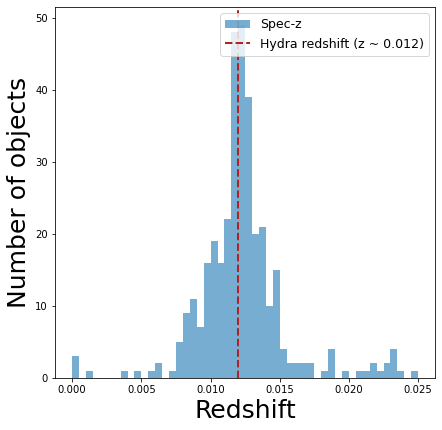

In [20]:
fontsize = 25
labelsize = 20

zmax = 0.025
mask_sz = (z > 0.0) & (z < zmax) 

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)

n, bins, patches = ax1.hist(z[mask_sz], alpha=0.6, label='Spec-z', bins=50, range=(0, zmax), histtype='stepfilled')
# ax1.set_title(r'PROB_GAL $ > $ {:.1f},'.format(pmin), fontsize=fontsize)
ax1.set_xlabel("Redshift", fontsize=fontsize)
ax1.set_ylabel("Number of objects", fontsize=fontsize)
ax1.axvline(x=0.012, linestyle='--', color='firebrick', linewidth=2.0, label='Hydra redshift (z ~ 0.012)')
# ax1.axvline(x=0.0165, linestyle='--', color='navy', linewidth=3.0)
ax1.legend(fontsize=fontsize*0.5)

In [9]:
z_lower = 0.0065
z_upper = 0.0175

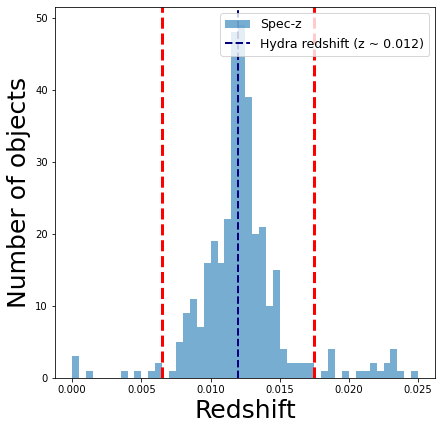

In [22]:
#Define the redshift interval for your cluster (by eye (?)) 
z_lower = 0.0065
z_upper = 0.0175

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)

n, bins, patches = ax1.hist(z[mask_sz], alpha=0.6, label='Spec-z', bins=50, range=(0, zmax), histtype='stepfilled')
# ax1.set_title(r'PROB_GAL $ > $ {:.1f},'.format(pmin), fontsize=fontsize)
ax1.set_xlabel("Redshift", fontsize=fontsize)
ax1.set_ylabel("Number of objects", fontsize=fontsize)
ax1.axvline(x=0.012, linestyle='--', color='navy', linewidth=2.0, label='Hydra redshift (z ~ 0.012)')
ax1.axvline(x=z_lower, linestyle='--', color='red', linewidth=3.0)
ax1.axvline(x=z_upper, linestyle='--', color='red', linewidth=3.0)
ax1.legend(fontsize=fontsize*0.5)

In [23]:
mask_hydra = (z > z_lower) & (z < z_upper) & (rmag_sz < 21.29)
galaxies_in_hydra = np.sum(mask_hydra)

#### Compute the photo-z selection again to see how many of the galaxies actually in Hydra are selected based on the photo-zs

In [24]:
selected_galaxies = 0
n = 0
f = 5

for r in np.unique(rmag_sz[mask_hydra]):   
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
      
    if ((z_cluster - f*sigma_nmad) >= 0):
        mask = (rmag_sz[mask_hydra] == r) & (zml_sz[mask_hydra] > (z_cluster 
                                                - f*sigma_nmad)) & (zml_sz[mask_hydra] < (z_cluster + f*sigma_nmad))
        
    if ((z_cluster - f*sigma_nmad) < 0):
        mask = (rmag_sz[mask_hydra] == r) & (zml_sz[mask_hydra] > 0) & (zml_sz[mask_hydra] 
                                                < (z_cluster + f*sigma_nmad))

    n += np.sum(mask)
    print("Total number of objects: {:6d}".format(n))
    
    selected_galaxies += np.sum(mask)  

Total number of objects:      1
Total number of objects:      2
Total number of objects:      3
Total number of objects:      4
Total number of objects:      5
Total number of objects:      6
Total number of objects:      7
Total number of objects:      8
Total number of objects:      9
Total number of objects:     10
Total number of objects:     11
Total number of objects:     12
Total number of objects:     13
Total number of objects:     14
Total number of objects:     15
Total number of objects:     16
Total number of objects:     17
Total number of objects:     18
Total number of objects:     19
Total number of objects:     20
Total number of objects:     21
Total number of objects:     22
Total number of objects:     23
Total number of objects:     24
Total number of objects:     25
Total number of objects:     26
Total number of objects:     27
Total number of objects:     28
Total number of objects:     29
Total number of objects:     30
Total number of objects:     31
Total nu

Total number of objects:    267
Total number of objects:    267
Total number of objects:    268
Total number of objects:    269
Total number of objects:    270
Total number of objects:    271
Total number of objects:    272
Total number of objects:    273
Total number of objects:    274
Total number of objects:    275
Total number of objects:    276
Total number of objects:    277
Total number of objects:    278
Total number of objects:    279
Total number of objects:    280
Total number of objects:    281
Total number of objects:    281
Total number of objects:    282
Total number of objects:    283
Total number of objects:    284
Total number of objects:    285
Total number of objects:    286
Total number of objects:    287
Total number of objects:    288
Total number of objects:    289
Total number of objects:    290
Total number of objects:    291
Total number of objects:    292
Total number of objects:    293
Total number of objects:    294
Total number of objects:    295
Total nu

#### Compute the completeness of the selection

In [25]:
completeness = selected_galaxies / galaxies_in_hydra
print("completeness = {:.3f}".format(completeness))

completeness = 0.978


### 97,8% completeness

In [24]:
table_final = pd.read_csv("CHANCES-catalogues/Hydra_Catalogue.csv", usecols=['OBJECT_ID', 'RA_J2000', 'Dec_J2000', 
                                                                             'zml', 'RFIBER', 'RMAG'])

In [25]:
rmag = table_final["RMAG"]
zml = table_final["zml"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


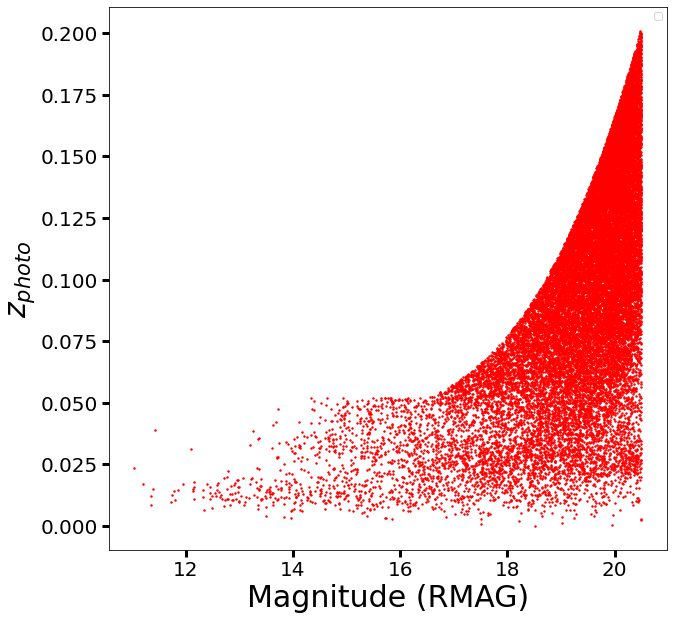

In [27]:
fontsize=30
labelsize=20

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.scatter(rmag, zml, s=2.0, color='red')
ax.set_xlabel("Magnitude (RMAG)", fontsize=fontsize)
ax.set_ylabel(r"$z_{photo}$", fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize=labelsize, width=3, length=7)
ax.yaxis.set_tick_params(labelsize=labelsize, width=3, length=7)
ax.legend()

## Comparisons between photoz and specz

In [3]:
table_spec = pd.read_csv("../Hydra-analysis/tables_speczs/SpecZ_Catalogue_20221206.csv")
table_cluster = pd.read_csv("CHANCES-catalogues/Hydra_Catalogue.csv")

/tmp/ipykernel_16327/1681453170.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  table_spec = pd.read_csv("../Hydra-analysis/tables_speczs/SpecZ_Catalogue_20221206.csv")


In [7]:
ra1 = np.asarray(table_cluster['RA_J2000'])
dec1 = np.asarray(table_cluster['Dec_J2000'])

ra2 = np.asarray(table_spec['RA'])
dec2 = np.asarray(table_spec['DEC'])

In [12]:
#=====================
#Crossmatch the CHANCES photometric catalogue with the spectroscopic catalogue
#Doing the crossmatch with TOPCAT, we get a very similar number of objects, so it may be working fine
#=====================

c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
#idx, d2d, d3d = c.match_to_catalog_sky(catalog)

max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [14]:
#=====================
#The idea here is to create a catalogue in which the objects without spectroscopic data will have it added as empty columns
#=====================

RA_T = []
DEC_T = []
redshift = []
e_z_T = []
f_z_T = []
class_spec_T = []
source_T = []


for i in range(len(table_cluster)):
    if sep_constraint[i] == True:
        redshift += [table_spec['z'][idx[i]]]
        RA_T += [table_spec['RA'][idx[i]]]
        DEC_T += [table_spec['DEC'][idx[i]]]
        e_z_T += [table_spec['e_z'][idx[i]]]
        f_z_T += [table_spec['f_z'][idx[i]]]
        class_spec_T += [table_spec['class_spec'][idx[i]]]
        source_T += [table_spec['source'][idx[i]]]
    else:
        redshift += ['']
        RA_T += ['']
        DEC_T += ['']
        e_z_T += ['']
        f_z_T += ['']
        class_spec_T += ['']
        source_T += ['']


df1 = pd.DataFrame(table_cluster)
df1['RA_spec']= RA_T
df1['DEC_spec']= DEC_T
df1['z_spec']= redshift
df1['e_z']= e_z_T
df1['f_z']= f_z_T
df1['class_spec']= class_spec_T
df1['source']= source_T

df1.to_csv('CHANCES-catalogues/Hydra_Catalogue_SpecZ_Crossmatch.csv',index=False)

#### Make plots

In [25]:
final_catalogue = pd.read_csv("tables-photometric/Hydra_Catalogue_SpecZ_Crossmatch.csv")

In [26]:
zspec = final_catalogue["z"]

In [27]:
#z_lower and z_upper above in the code, when selecting for specz galaxies in the cluster
mask_plot = (zspec > z_lower) & (zspec < z_upper)  
galaxies_in_plot = np.sum(mask_plot)
print("Number of specz galaxies in the cluster: {:5d}".format(galaxies_in_plot))

Number of specz galaxies in the cluster:   336


In [28]:
fontsize = 25
labelsize = 20

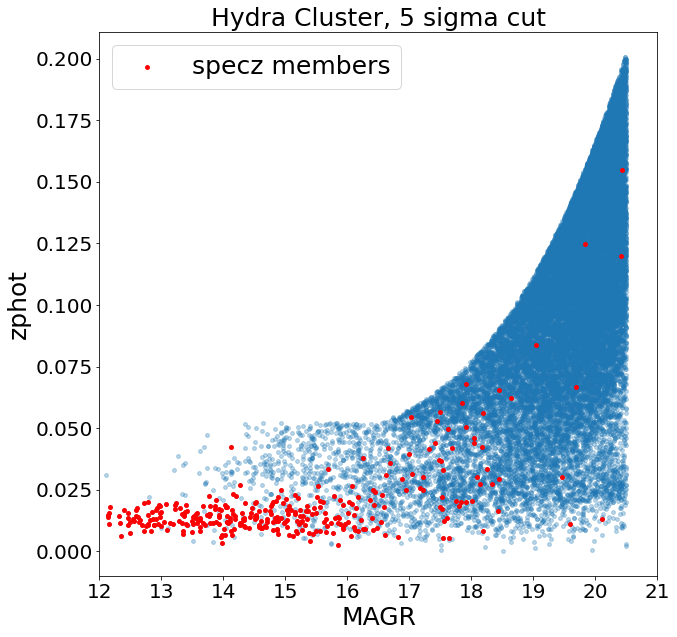

In [30]:
fig = plt.figure(figsize=(10, 10))
#ax1 = fig.add_subplot(221)
plt.scatter(final_catalogue['RMAG'],final_catalogue['zml'],  alpha=0.3, s=15)
plt.scatter(final_catalogue['RMAG'][mask_plot],final_catalogue['zml'][mask_plot], s=15 , c= 'r', label = 'specz members')
plt.xlabel('MAGR',fontsize=fontsize)
plt.ylabel('zphot', fontsize=fontsize)
plt.xlim(12, 21)
plt.title("Hydra Cluster, 5 sigma cut", fontsize=fontsize)
plt.yticks(fontsize=labelsize)
plt.xticks(fontsize=labelsize)
plt.legend(fontsize=fontsize)

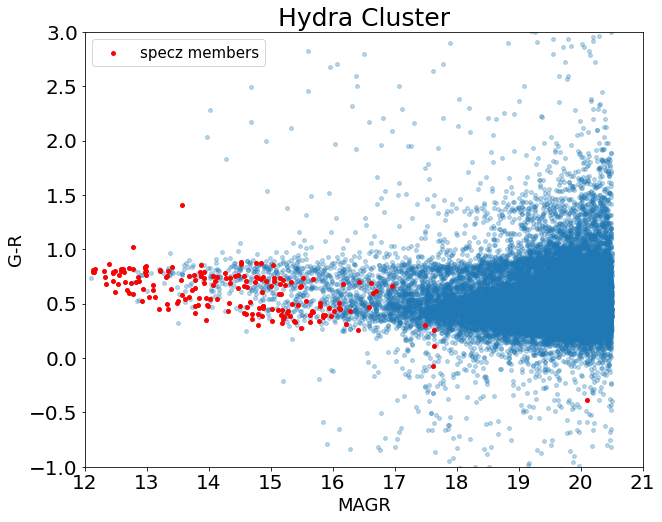

In [45]:
fig = plt.figure(figsize=(10, 8))
#ax1 = fig.add_subplot(221)
plt.scatter(final_catalogue['RMAG_1'],final_catalogue['G_R'],  alpha=0.3, s=15 )
plt.scatter(final_catalogue['RMAG_1'][mask_plot],final_catalogue['G_R'][mask_plot], s=15, c= 'r', label = 'specz members' )
plt.title("Hydra Cluster", fontsize=fontsize)
plt.xlabel('MAGR',fontsize=18)
plt.ylabel('G-R', fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(12, 21)
plt.ylim(-1, 3)
plt.legend(fontsize = 15)

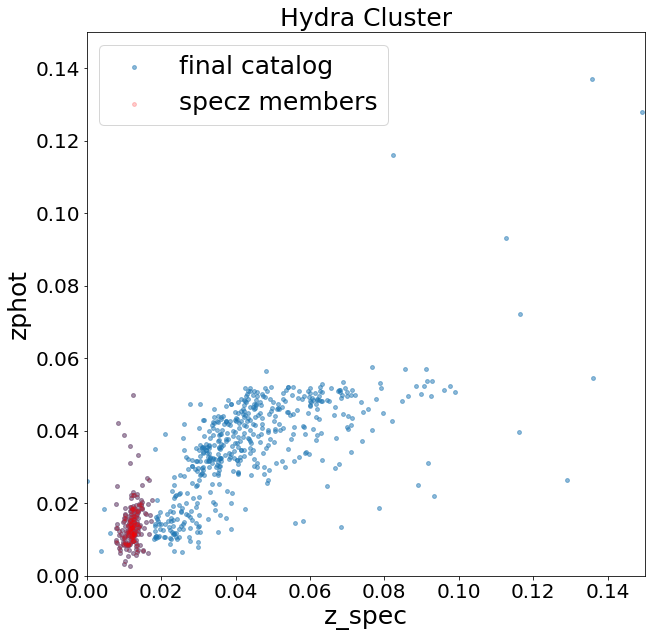

In [46]:
fig = plt.figure(figsize=(10, 10))

#plt.scatter(z,zml_sz,  alpha=0.3, s=15)
plt.scatter(final_catalogue['z_spec'],final_catalogue['zml'],label='final catalog' , s=15, alpha = 0.5)
plt.scatter(final_catalogue['z_spec'][mask_plot],final_catalogue['zml'][mask_plot], c='r', s=15,label='specz members',  alpha=0.2)
plt.xlabel('z_spec',fontsize=fontsize)
plt.ylabel('zphot', fontsize=fontsize)
plt.xlim(0,0.15)
plt.ylim(0, 0.15)
plt.title("Hydra Cluster", fontsize=fontsize)
plt.yticks(fontsize=labelsize)
plt.xticks(fontsize=labelsize)
plt.legend(fontsize=fontsize)
# plt.xlim(0.15)

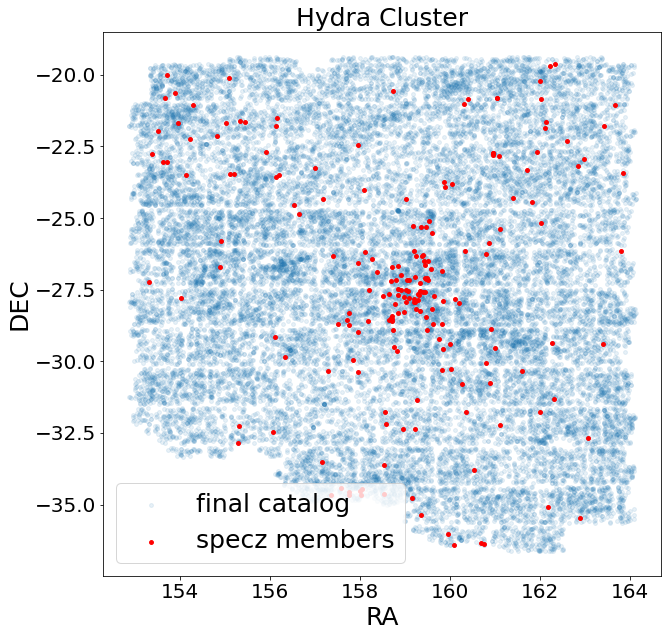

In [48]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(final_catalogue['RA_J2000_1'],final_catalogue['Dec_J2000_1'],label='final catalog' , s=15, alpha = 0.1)
plt.scatter(final_catalogue['RA_J2000_1'][mask_plot],final_catalogue['Dec_J2000_1'][mask_plot], c='r', s=15,label='specz members',  alpha=1)
plt.xlabel('RA',fontsize=fontsize)
plt.ylabel('DEC', fontsize=fontsize)
#plt.xlim(0,0.3)
#plt.ylim(0, 0.3)
plt.title("Hydra Cluster", fontsize=fontsize)
plt.yticks(fontsize=labelsize)
plt.xticks(fontsize=labelsize)
plt.legend(fontsize=fontsize)

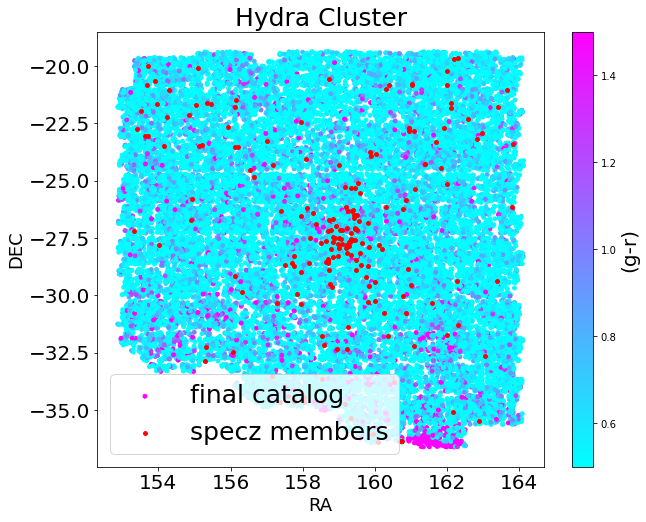

In [56]:
#cm = plt.cm.get_camp('tab20c')
import matplotlib.cm as cm
fig = plt.figure(figsize=(10, 8))

s=plt.scatter(final_catalogue['RA_J2000_1'],final_catalogue['Dec_J2000_1'],label='final catalog' , c=final_catalogue['G_R'], s=15, cmap=cm.cool,vmin=0.5,vmax=1.5)
plt.scatter(final_catalogue['RA_J2000_1'][mask_plot],final_catalogue['Dec_J2000_1'][mask_plot], c='r', s=15,label='specz members',  alpha=1)
cbar=plt.colorbar(s)
cbar.set_label(label=r'(g-r)', fontsize=labelsize)
plt.xlabel('RA',fontsize=18)
plt.ylabel('DEC', fontsize=18)
plt.title("Hydra Cluster", fontsize=fontsize)
plt.yticks(fontsize=labelsize)
plt.xticks(fontsize=labelsize)
plt.legend(fontsize=fontsize)